In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
dF = pd.read_csv('2016_Denver_Bike_Trip_Data.csv',  dtype={'Bike':object})

In [5]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419611 entries, 0 to 419610
Data columns (total 11 columns):
User's Program        419611 non-null object
User ID               419611 non-null int64
Membership Type       419611 non-null object
Bike                  419611 non-null object
Checkout Date         419611 non-null object
Checkout Time         419611 non-null object
Checkout Kiosk        419611 non-null object
Return Date           419611 non-null object
Return Time           419611 non-null object
Return Kiosk          419611 non-null object
Duration (Minutes)    419611 non-null int64
dtypes: int64(2), object(9)
memory usage: 35.2+ MB


In [6]:
# rename columns to make them more descriptive and replace spaces with special characters with underscores
new_colnames = ['User_Program', 'User_ID', 'Membership_Type', 'Bike_Number', 'Checkout_Date', 'Checkout_Time',
                'Checkout_Kiosk', 'Return_Date', 'Return_Time', 'Return_Kiosk', 'Trip_Duration']
dF.columns = new_colnames

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419611 entries, 0 to 419610
Data columns (total 11 columns):
User_Program       419611 non-null object
User_ID            419611 non-null int64
Membership_Type    419611 non-null object
Bike_Number        419611 non-null object
Checkout_Date      419611 non-null object
Checkout_Time      419611 non-null object
Checkout_Kiosk     419611 non-null object
Return_Date        419611 non-null object
Return_Time        419611 non-null object
Return_Kiosk       419611 non-null object
Trip_Duration      419611 non-null int64
dtypes: int64(2), object(9)
memory usage: 35.2+ MB


In [8]:
dX = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] < 26)]

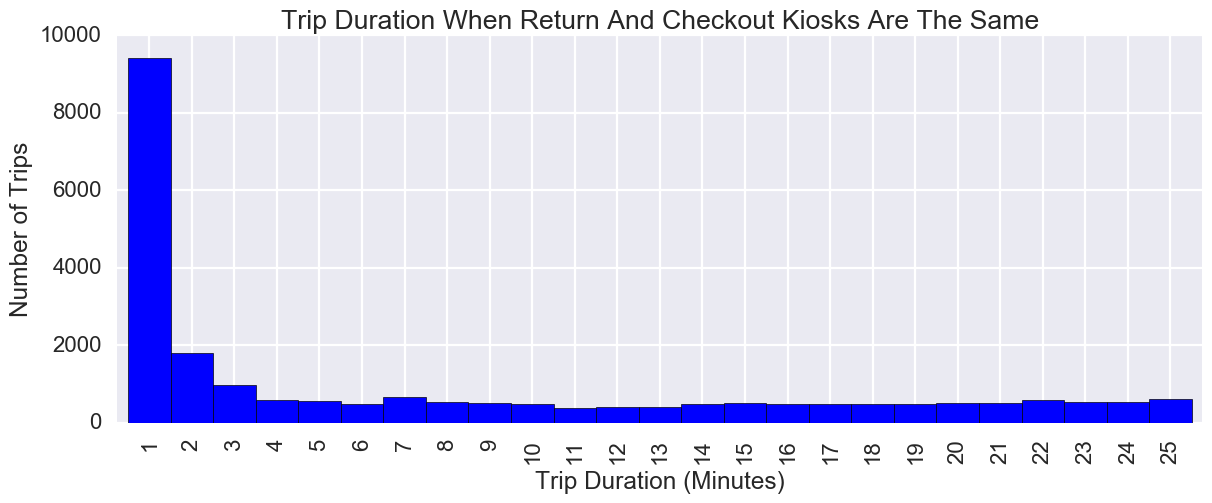

In [9]:
ax = dX.groupby('Trip_Duration').size().plot(kind='bar', figsize=(14,5), color='blue', width=1.0, xlim=(0,15))
plt.title("Trip Duration When Return And Checkout Kiosks Are The Same")
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Number of Trips')
plt.show()

In [10]:
# select rows that have the same Checkout and Return Kiosks, a trip duration of greater than 1 minute and Membership Type
# equal to 'Not Applicable'
dU = dF.groupby(['User_ID', 'Checkout_Time']), dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] > 1) & 
        (dF["Membership_Type"] == 'Not Applicable')]

In [90]:
# pick a random user_id to investigate bike use pattern
dB = dF.loc[dF['User_ID'] == 467615]
dB.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Distance
295126,Denver B-cycle,467615,Not Applicable,401,2016-04-13,06:45:00,17th & Franklin,2016-04-13,06:56:00,11th & Emerson,11,1.990
295127,Denver B-cycle,467615,Not Applicable,133,2016-04-13,06:45:00,17th & Franklin,2016-04-13,06:56:00,11th & Ogden,11,1.090
295143,Denver B-cycle,467615,Not Applicable,571,2016-04-13,07:05:00,16th & Broadway,2016-04-13,07:22:00,15th & Curtis,17,0.890
295144,Denver B-cycle,467615,Not Applicable,135,2016-04-13,07:05:00,16th & Broadway,2016-04-13,10:55:00,14th & Ogden,230,0.850
295148,Denver B-cycle,467615,Not Applicable,645,2016-04-13,07:08:00,16th & Broadway,2016-04-13,07:21:00,15th & Curtis,13,0.890


In [13]:
# What if Trip Duration is greater than 5 minutes?
dF = dF.loc[dF['Trip_Duration'] > 5]

In [91]:
dF.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Distance
0,Denver B-cycle,1062815,Annual Plus (Denver B-cycle),544,2016-12-31,05:08:00,15th & Curtis,2016-12-31,05:20:00,Denver Public Library,12,0.960
1,Denver B-cycle,1445221,24-hour Kiosk Only (Denver B-cycle),505,2016-12-31,07:22:00,16th & Sherman,2016-12-31,08:03:00,16th & Wynkoop,41,1.475
2,Denver B-cycle,1296335,Monthly (Denver B-cycle),210,2016-12-31,07:23:00,22nd & Market,2016-12-31,07:26:00,18th & Arapahoe,3,0.575
3,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),718,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,3.360
4,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),267,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,3.360


In [15]:
# need to get rid of rows with 'Not Applicable' in Membership_Type column as seen from above cells
dF = dF.loc[dF['Membership_Type'] != 'Not Applicable']

In [92]:
dF.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Distance
0,Denver B-cycle,1062815,Annual Plus (Denver B-cycle),544,2016-12-31,05:08:00,15th & Curtis,2016-12-31,05:20:00,Denver Public Library,12,0.960
1,Denver B-cycle,1445221,24-hour Kiosk Only (Denver B-cycle),505,2016-12-31,07:22:00,16th & Sherman,2016-12-31,08:03:00,16th & Wynkoop,41,1.475
2,Denver B-cycle,1296335,Monthly (Denver B-cycle),210,2016-12-31,07:23:00,22nd & Market,2016-12-31,07:26:00,18th & Arapahoe,3,0.575
3,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),718,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,3.360
4,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),267,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,3.360


In [17]:
# Add new columns
dF.insert(11,'Trip_Distance',0)

In [18]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293452 entries, 0 to 419609
Data columns (total 12 columns):
User_Program       293452 non-null object
User_ID            293452 non-null int64
Membership_Type    293452 non-null object
Bike_Number        293452 non-null object
Checkout_Date      293452 non-null object
Checkout_Time      293452 non-null object
Checkout_Kiosk     293452 non-null object
Return_Date        293452 non-null object
Return_Time        293452 non-null object
Return_Kiosk       293452 non-null object
Trip_Duration      293452 non-null int64
Trip_Distance      293452 non-null int64
dtypes: int64(3), object(9)
memory usage: 29.1+ MB


In [19]:
dF.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Denver B-cycle,1062815,Annual Plus (Denver B-cycle),544,2016-12-31,05:08:00,15th & Curtis,2016-12-31,05:20:00,Denver Public Library,12,0
1,Denver B-cycle,1445221,24-hour Kiosk Only (Denver B-cycle),505,2016-12-31,07:22:00,16th & Sherman,2016-12-31,08:03:00,16th & Wynkoop,41,0
3,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),718,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,0
4,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),267,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,0
5,Denver B-cycle,1410481,Monthly (Denver B-cycle),51,2016-12-31,07:53:00,14th & Stout,2016-12-31,08:02:00,Denver Health,9,0


In [20]:
# read in Kiosk information from the Denver Bike Share public data site
dC= pd.read_excel('october2016_kioskinfo.xlsx')

In [21]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
  Kiosk Name    89 non-null object
Address         89 non-null object
Longitude       89 non-null float64
Latitude        89 non-null float64
Total Docks     89 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.6+ KB


In [22]:
dC.head()

,Kiosk Name,Address,Longitude,Latitude,Total Docks
0,10th & Osage,1005 Osage St,-105.005,39.732,15
1,11th & Broadway,1085 Broadway St.,-104.988,39.734,11
2,11th & Delaware,1095 Delaware St,-104.993,39.734,13
3,11th & Emerson,900 E. 11th Ave,-104.976,39.734,11
4,11th & Ogden,990 E. 11th Ave.,-104.976,39.734,11


In [23]:
# use descriptive column names
new_colnames = ['Checkout_Kiosk', 'Checkout_Kiosk_Address', 'Checkout_Kiosk_Longitude', 
                'Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Total_Docks']
dC.columns = new_colnames

In [24]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
Checkout_Kiosk                89 non-null object
Checkout_Kiosk_Address        89 non-null object
Checkout_Kiosk_Longitude      89 non-null float64
Checkout_Kiosk_Latitude       89 non-null float64
Checkout_Kiosk_Total_Docks    89 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.6+ KB


In [25]:
# don't need address and docks for retrieving distances from Google Distance API
dC.drop(['Checkout_Kiosk_Address', 'Checkout_Kiosk_Total_Docks'], axis = 1, inplace=True)

In [26]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
Checkout_Kiosk              89 non-null object
Checkout_Kiosk_Longitude    89 non-null float64
Checkout_Kiosk_Latitude     89 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


In [27]:
# save dataframe to csv file for use in getting distances from Googe Distance API
dC.to_csv('Denver_Bike_Checkout_Kiosks_Details.csv')

In [28]:
# make a copy for Return Kiosks
dR = dC.copy(deep=True)

In [29]:
dR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
Checkout_Kiosk              89 non-null object
Checkout_Kiosk_Longitude    89 non-null float64
Checkout_Kiosk_Latitude     89 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


In [30]:
# use descriptive column names
new_colnames = ['Return_Kiosk', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude']
dR.columns = new_colnames

In [31]:
dR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
Return_Kiosk              89 non-null object
Return_Kiosk_Longitude    89 non-null float64
Return_Kiosk_Latitude     89 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


In [32]:
# save dataframe to csv file for use in getting distances from Googe Distance API
dR.to_csv('Denver_Bike_Return_Kiosks_Details.csv')

In [33]:
# open Checkout Kiosk csv file for reading
with open('Denver_Bike_Checkout_Kiosks_Details.csv', 'r') as f:
    reader = csv.reader(f)
    CK_list = list(reader)
f.close()

In [34]:
# open Return Kiosk file for reading
with open('Denver_Bike_Return_Kiosks_Details.csv', 'r') as f:
    reader = csv.reader(f)
    RT_list = list(reader)
f.close()

In [35]:
row_header = []
with open("Denver_Bike_Kiosks_Details.csv", "w", newline='') as f:
    writer = csv.writer(f)
    row_header = ["Checkout_Kiosk", "Checkout_Kiosk_Latitude", "Checkout_Kiosk_Longitude",
         "Return_Kiosk", "Return_Kiosk_Latitude", "Return_Kiosk_Longitude"]
    writer.writerow(row_header)
    for CheckoutKioskRow in CK_list[1:]:
        CheckoutKiosk = CheckoutKioskRow[1]
        for ReturnKioskRow in RT_list[1:]:
            if CheckoutKiosk in ReturnKioskRow[1]:
                pass
            else:
                result = (CheckoutKioskRow[1], CheckoutKioskRow[3], CheckoutKioskRow[2], 
                          ReturnKioskRow[1], ReturnKioskRow[3], ReturnKioskRow[2])
                writer.writerow(result)
f.close()

In [36]:
# group Trips (dF) dataframe by Kiosks and count
kioskTripCount = pd.DataFrame({'count' : dF.groupby([ 'Checkout_Kiosk', 'Return_Kiosk']).size()}).reset_index()

In [37]:
kioskTripCount.to_csv("Kiosk_Trips_Count.csv", index=False)

In [38]:
with open('Kiosk_Trips_Count.csv', 'r') as f:
    reader = csv.reader(f)
    Trips_list = list(reader)
f.close()

In [39]:
with open('Denver_Bike_Kiosks_Distances_Durations.csv', 'r') as f:
    reader = csv.reader(f)
    Stations_list = list(reader)
f.close()

In [40]:
row_header = []
with open("Kiosk_Trips_Count_Temp.csv", "w", newline='') as f:
    writer = csv.writer(f)
    row_header = ["Checkout_Kiosk", "Return_Kiosk", "Count", "Distance", "Marker"]
    writer.writerow(row_header)
    for Trips_row in Trips_list[1:]:
        Trips_Checkout_Return_Station = [Trips_row[0], Trips_row[1]]
        writer.writerow ([Trips_row[0], Trips_row[1], Trips_row[2]])
        for Stations_row in Stations_list[1:]:
            Stations_Checkout_Return_Station = [Stations_row[0], Stations_row[3]]
            if Trips_Checkout_Return_Station == Stations_Checkout_Return_Station:
                result = [Trips_row[0], Trips_row[1], Trips_row[2], Stations_row[10], "Keep"]
                writer.writerow(result)
f.close()

In [41]:
kioskCount = pd.read_csv("Kiosk_Trips_Count_Temp.csv")

In [42]:
#yhat = dF[(dF.Marker == "Keep")]
keepMarker = kioskCount[(kioskCount.Marker == "Keep")]

In [43]:
keepMarker.to_csv("Kiosk_Trips_Count_Temp.csv", index=False)

In [44]:
with open('Kiosk_Trips_Count_Temp.csv', 'r') as f:
    reader = csv.reader(f)
    Distances_list = list(reader)
f.close()

In [45]:
# dF = pd.read_csv('Denver_B-Cycle_Trip_Data_2016.csv', dtype={'Bike_Number':object})
with open('2016_Denver_Bike_Trip_Data.csv', 'r') as f:
    reader = csv.reader(f)
    Trips_list = list(reader)
f.close()

In [46]:
row_header = []
with open("draft_Trips.csv", "w", newline='') as f:
    writer = csv.writer(f)
    row_header = ["User_Program", "User_ID", "Membership_Type", "Bike_Number", "Checkout_Date", 
         "Checkout_Time", "Checkout_Kiosk", "Return_Date", "Return_Time", "Return_Kiosk", "Trip_Duration", "Distance"]
    writer.writerow(row_header)
    for Trips_row in Trips_list[1:]:
        Trips_Checkout_Return_Station = [Trips_row[6], Trips_row[9]]
        for Distances_row in Distances_list[1:]:
            Distances_Checkout_Return_Station = [Distances_row[0], Distances_row[1]]
            if Trips_Checkout_Return_Station == Distances_Checkout_Return_Station:
                result = [Trips_row[0], Trips_row[1], Trips_row[2], Trips_row[3], Trips_row[4], 
                          Trips_row[5], Trips_row[6], Trips_row[7], Trips_row[8], Trips_row[9], 
                          Trips_row[10], Distances_row[3]]
                writer.writerow(result)
f.close()

In [48]:
dF = pd.read_csv("draft_Trips.csv",  dtype={'Bike_Number':object})

In [50]:
# indicates 371,853 B-cycle rides in 2016
# Denver B-cycle Annual Report 2016 reports 354,652 total trips. It is possible the report does not include
# non-Denver Bike Memberships
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371854 entries, 0 to 371853
Data columns (total 12 columns):
User_Program       371854 non-null object
User_ID            371854 non-null int64
Membership_Type    371854 non-null object
Bike_Number        371854 non-null object
Checkout_Date      371854 non-null object
Checkout_Time      371854 non-null object
Checkout_Kiosk     371854 non-null object
Return_Date        371854 non-null object
Return_Time        371854 non-null object
Return_Kiosk       371854 non-null object
Trip_Duration      371854 non-null int64
Distance           371854 non-null float64
dtypes: float64(1), int64(2), object(9)
memory usage: 34.0+ MB


In [51]:
dF.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Distance
0,Denver B-cycle,1062815,Annual Plus (Denver B-cycle),544,2016-12-31,05:08:00,15th & Curtis,2016-12-31,05:20:00,Denver Public Library,12,0.960
1,Denver B-cycle,1445221,24-hour Kiosk Only (Denver B-cycle),505,2016-12-31,07:22:00,16th & Sherman,2016-12-31,08:03:00,16th & Wynkoop,41,1.475
2,Denver B-cycle,1296335,Monthly (Denver B-cycle),210,2016-12-31,07:23:00,22nd & Market,2016-12-31,07:26:00,18th & Arapahoe,3,0.575
3,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),718,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,3.360
4,Denver B-cycle,1478018,24-hour Kiosk Only (Denver B-cycle),267,2016-12-31,07:51:00,19th & Market,2016-12-31,08:39:00,Decatur Federal Light Rail,48,3.360


In [55]:
userProgram = dF.groupby('User_Program')

In [56]:
userProgram.size()

User_Program
Austin B-cycle                117
Battle Creek B-cycle           10
Boulder B-cycle              6989
Bublr Bikes                    19
Charlotte B-cycle              24
Cincy Red Bike                 24
Denver B-cycle             363758
Des Moines B-cycle            448
Fort Worth Bike Sharing         5
GREENbike                      84
Houston B-cycle               151
Indy - Pacers Bikeshare        32
Kansas City B-cycle            14
Link Dayton Bike Share          8
Madison B-cycle               125
Nashville B-cycle              44
Spartanburg BCycle              2
dtype: int64

In [ ]:
# With User_Program == 'Denver B-cycle', total rides = 363,758, which are still more than 8096 trips (371,854 - 363,758)
# than reported by Denver B-Cycle

In [57]:
denverB = dF[dF['User_Program'] == 'Denver B-cycle']

In [60]:
denverB['Distance'].sum()

552392.8349999373

In [61]:
# If only Denver B-cycle membership is used, 552,393 miles were ridden

In [62]:
dF['Distance'].sum()

562646.3899999353

In [63]:
# Denver B-cycle reports 755,409 miles ridden, a significant delta of 192,763 miles

In [87]:
mostPopularKiosk = dF.groupby('Checkout_Kiosk', sort=True).sum()

In [94]:
mostPopularKiosk.head(10)

,User_ID,Trip_Duration,Distance
Checkout_Kiosk,,,
10th & Osage,2615830046,90805,5172.390
11th & Broadway,4320171559,137829,6642.045
11th & Delaware,4374632674,95285,7176.415
11th & Emerson,4337448880,106396,6988.225
11th & Ogden,2957564916,69747,5505.595
12th & Columbine,1681592264,65297,5279.745
12th & Sherman,3999920051,90267,6541.190
1350 Larimer,8019886956,302436,14839.700
13th & Marion,4736329544,100724,9824.465
